Gene-gene Topology experiments
1. Use pbmc12k dataset, randomly select gene-gene pairs;
2. Get the embeddings for the selected genes. (GeneFormer, GeneMamba, scGPT, scFoundation)
3. Calculate the distance between the gene-gene pairs (Euclidean distance), get the adjacent matrix of the selected elements;
4. Set the threshold as the mean value of the elements;
5. Cut-off the distance to 0 and 1 based on the threshold value;
6. Calculate the Jaccard distance among the adjacent matrices.
7. calculate the overlapping gene-geen pairs.
8. visualize the Gene-gene topology figure.


In [1]:
import sys
import os
import torch

from dotmap import DotMap

import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
# import anndata as ad
from scipy.sparse import csr_matrix
import scanpy as sc

import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "../..")))

from genemamba.models import GeneMamba
from genemamba.utils import load_g2v, pearson_correlation, kl_divergence, jensen_shannon_divergence


/project/zhiwei/cq5/miniconda3/envs/mamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import PretrainedConfig

config = PretrainedConfig.from_dict({
    "d_model": 512,
    "mamba_layer": 24,
})


model = GeneMamba(config, model_path="/path/to/ckpts/downstream/GeneMamba/checkpoint", tokenizer_path="/path/to/gene_tokenizer.json", args=None)

/mmfs1/project/zhiwei/cq5/PythonWorkSpace/mamba_dev/genemamba/models/models.py:192: ResourceWarning: unclosed file <_io.BufferedReader name='/mmfs1/project/zhiwei/cq5/PythonWorkSpace/mamba_dev/genemamba/models/id2symbol.pkl'>
  self.id2symbol = pickle.load(open(os.path.join(os.path.dirname(__file__), "id2symbol.pkl"), "rb"))
/mmfs1/project/zhiwei/cq5/PythonWorkSpace/mamba_dev/genemamba/models/models.py:193: ResourceWarning: unclosed file <_io.BufferedReader name='/mmfs1/project/zhiwei/cq5/PythonWorkSpace/mamba_dev/genemamba/models/symbol2id.pkl'>
  self.symbol2id = pickle.load(open(os.path.join(os.path.dirname(__file__), "symbol2id.pkl"), "rb"))
/project/zhiwei/cq5/miniconda3/envs/mamba/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded model from  /project/zhiwei/cq5/PythonWorkSpace/mamba_dev/ckpts/downstream/GeneMamba/checkpoint


In [3]:
dataset_name = "pbmc12k"

file_path = f'/path/to/downstream/origin/{dataset_name}.h5ad'

adata = sc.read_h5ad(file_path)

In [ ]:
g2v = load_g2v("resources/gene2vec_embeddings.txt")

In [4]:
scgpt = pd.read_csv("resources/scGPT_genenames.csv")
scgpt_embeddings = np.load('resources/scGPT_gene.npy')
wv_scgpt, vocabulary_scgpt = scgpt_embeddings, scgpt["gene_name"].to_numpy()

input_gene_to_idx = {gene: idx for idx, gene in enumerate(vocabulary_scgpt)}

scgpt embedding shape is: (60697, 512)
scgpt gene shape is: (60697,)


In [6]:
s_mamba = set(model.symbol2id.keys())
s_g2v = set(g2v.keys())
s_scgpt = set(input_gene_to_idx.keys())

gene_common = s_mamba.intersection(s_g2v).intersection(s_scgpt)
len(gene_common)

15981

In [7]:
def get_results(model_name, model, g2v, pairs_df, return_all=False):

    correlations = {"pearson_correlation": [], "cosine_similarity": []}

    gene1_embeddings = []
    gene2_embeddings = []
    common_pairs = []
    for i in range(pairs_df.shape[0]):
        gene1 = pairs_df.iloc[i]["Gene1"]
        gene2 = pairs_df.iloc[i]["Gene2"]

        if gene1 in gene_common and gene2 in gene_common:
            
            common_pairs.append([gene1, gene2])

            if model_name == "GeneMamba":
                try:
                    gene1_tensor = torch.tensor(model.tokenizer.encode(model.symbol2id[gene1]), dtype = torch.int64).to(model.device)
                    gene2_tensor = torch.tensor(model.tokenizer.encode(model.symbol2id[gene2]), dtype = torch.int64).to(model.device)
                except KeyError:
                    print(f"UNK gene: {gene1} or {gene2}")
                    continue

                gene1_embedding = model.get_gene_embedding(gene1_tensor)
                gene2_embedding = model.get_gene_embedding(gene2_tensor)
            elif model_name == "g2v":
                try:
                    gene1_embedding = torch.tensor(g2v[gene1]).unsqueeze(0).to("cpu")
                    gene2_embedding = torch.tensor(g2v[gene2]).unsqueeze(0).to("cpu")
                except KeyError:
                    print(f"G2V UNK gene: {gene1} or {gene2}")
                    continue
            elif model_name == "scgpt":
                try:
                    gene1_embedding = torch.tensor(wv_scgpt[input_gene_to_idx[gene1]]).unsqueeze(0).to(model.device)
                    gene2_embedding = torch.tensor(wv_scgpt[input_gene_to_idx[gene2]]).unsqueeze(0).to(model.device)
                except KeyError:
                    print(f"G2V UNK gene: {gene1} or {gene2}")
                    continue
            elif model_name == "scFoundation":
                try:
                    gene1_embedding = torch.tensor(scFoundation_gene_embeddings[scFoundation_names_list.index(gene1)]).unsqueeze(0).to(model.device)
                    gene2_embedding = torch.tensor(scFoundation_gene_embeddings[scFoundation_names_list.index(gene2)]).unsqueeze(0).to(model.device)
                except KeyError:
                    print(f"scFoundation UNK gene: {gene1} or {gene2}")
                    continue
        else:
            print(f"UNK gene: {gene1} or {gene2}")
            continue
    
        gene1_embeddings.append(gene1_embedding.cpu().detach().numpy())
        gene2_embeddings.append(gene2_embedding.cpu().detach().numpy())
    
    common_pairs_df = pd.DataFrame(common_pairs, columns=["Gene1", "Gene2"])

    gene1_embeddings = np.array(gene1_embeddings)
    gene2_embeddings = np.array(gene2_embeddings)

    if return_all == True:
        return gene1_embeddings, gene2_embeddings, common_pairs_df
    return gene1_embeddings, gene2_embeddings


In [8]:
# selecting random sample pairs
n_pairs = 30 
genes = adata.var_names
np.random.seed(42)
random_pairs = np.random.choice(genes, size=(n_pairs, 2), replace=False)

3346

In [9]:
random_pairs_df = pd.DataFrame(random_pairs, columns=["Gene1_Ensembl", "Gene2_Ensembl"])
random_pairs_df["Gene1"] = [model.id2symbol[gene] for gene in random_pairs_df["Gene1_Ensembl"]]
random_pairs_df["Gene2"] = [model.id2symbol[gene] for gene in random_pairs_df["Gene2_Ensembl"]]

In [10]:
gene1_embedding_mamba, gene2_embedding_mamba, common_df = get_results("GeneMamba", model, g2v, random_pairs_df, return_all=True)
gene1_embedding_g2v, gene2_embedding_g2v = get_results("g2v", model, g2v, random_pairs_df)
gene1_embedding_scgpt, gene2_embedding_scgpt = get_results("scgpt", model, g2v, random_pairs_df)

UNK gene: None or XPO4
UNK gene: GPI or None
UNK gene: DNM1L or None
UNK gene: SF3B5 or None
UNK gene: None or XPO4
UNK gene: GPI or None
UNK gene: DNM1L or None
UNK gene: SF3B5 or None
UNK gene: None or XPO4
UNK gene: GPI or None
UNK gene: DNM1L or None
UNK gene: SF3B5 or None


In [11]:
len(gene1_embedding_mamba), len(gene1_embedding_g2v), len(gene1_embedding_scgpt)

(26, 26, 26)

In [12]:
common_df.sample(5)

,Gene1,Gene2
0,DECR1,TBP
1,RALA,TRPV2
2,NKG7,SLC9A6
3,CBLL1,MRPL15
4,IL4R,PRMT3
5,CR2,CFH
6,CST7,NDUFAF1
7,TRAPPC6A,GDI1
8,GLA,PKIG
9,ZWINT,LY6G5C


3. Calculate the distance between the gene-gene pairs (Euclidean distance), get the adjacent matrix of the 100 * 100 elements;


In [13]:
gene1_embedding_mamba = np.squeeze(gene1_embedding_mamba)
gene2_embedding_mamba = np.squeeze(gene2_embedding_mamba)
gene1_embedding_g2v = np.squeeze(gene1_embedding_g2v)
gene2_embedding_g2v = np.squeeze(gene2_embedding_g2v)
gene1_embedding_scgpt = np.squeeze(gene1_embedding_scgpt)
gene2_embedding_scgpt = np.squeeze(gene2_embedding_scgpt)

gene1_embedding_mamba.shape, gene1_embedding_g2v.shape, gene1_embedding_scgpt.shape

((26, 768), (26, 200), (26, 512))

In [14]:
def is_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [15]:
def get_adjacent_matrix(gene1_embedding, gene2_embedding):
    """
    Compute the adjacency matrix for given gene embeddings.
    This function calculates the adjacency matrix by computing the pairwise Euclidean distances
    between two sets of gene embeddings. The distances are then converted to similarities by 
    subtracting from 1. The matrix is thresholded based on the mean value, setting values below 
    the threshold to 0 and values above or equal to the threshold to 1. The diagonal of the 
    adjacency matrix is set to 0.
    """
    adjacent_matrix = 1 - pairwise_distances(gene1_embedding, gene2_embedding, metric="euclidean")
    # assert that the matrix is symmetric
    assert is_symmetric(adjacent_matrix), "Matrix is not symmetric"
    
    threshold = np.mean(adjacent_matrix)
    _less_threshold = adjacent_matrix < threshold
    _greater_threshold = adjacent_matrix >= threshold
    adjacent_matrix[_less_threshold] = 0
    adjacent_matrix[_greater_threshold] = 1
    np.fill_diagonal(adjacent_matrix, 0)
    return adjacent_matrix

In [16]:
adjacent_matrix_mamba = get_adjacent_matrix(gene1_embedding_mamba, gene1_embedding_mamba)
adjacent_matrix_g2v = get_adjacent_matrix(gene1_embedding_g2v, gene1_embedding_g2v)
adjacent_matrix_scgpt = get_adjacent_matrix(gene1_embedding_scgpt, gene1_embedding_scgpt)

In [17]:
adjacent_matrix_mamba.shape, adjacent_matrix_g2v.shape, adjacent_matrix_scgpt.shape

((26, 26), (26, 26), (26, 26))

6. Calculate the Jaccard distance among the adjacent matrices.

In [18]:
# calculate the Jaccard distance among the adjacent matrices, make them into a distance matrix
from sklearn.metrics import jaccard_score

def get_jaccard_df(model_names, adjacent_matrices):
    jaccard_df = pd.DataFrame(columns=model_names, index=model_names)
    for i, model_name in enumerate(model_names):
        for j, model_name2 in enumerate(model_names):
            if i == j:
                jaccard_df.loc[model_name, model_name2] = 0
            else:
                jacaard = jaccard_score(adjacent_matrices[i].flatten(), adjacent_matrices[j].flatten())
                jaccard_df.loc[model_name, model_name2] = jacaard
    return jaccard_df

model_names = ["GeneMamba", "g2v", "scgpt"]
adjacent_matrices = [adjacent_matrix_mamba, adjacent_matrix_g2v, adjacent_matrix_scgpt]

jaccard_df = get_jaccard_df(model_names, adjacent_matrices)
jaccard_df

,GeneMamba,g2v,scgpt
GeneMamba,0,0.297561,0.263158
g2v,0.297561,0,0.170068
scgpt,0.263158,0.170068,0


In [19]:
intersection_matrix = np.logical_and(adjacent_matrix_mamba, adjacent_matrix_scgpt).astype(int)
overlapping_edges = np.argwhere(intersection_matrix == 1)

common_gene_names = common_df["Gene1"].to_numpy()
print(f"Common gene names: {common_gene_names}")

26

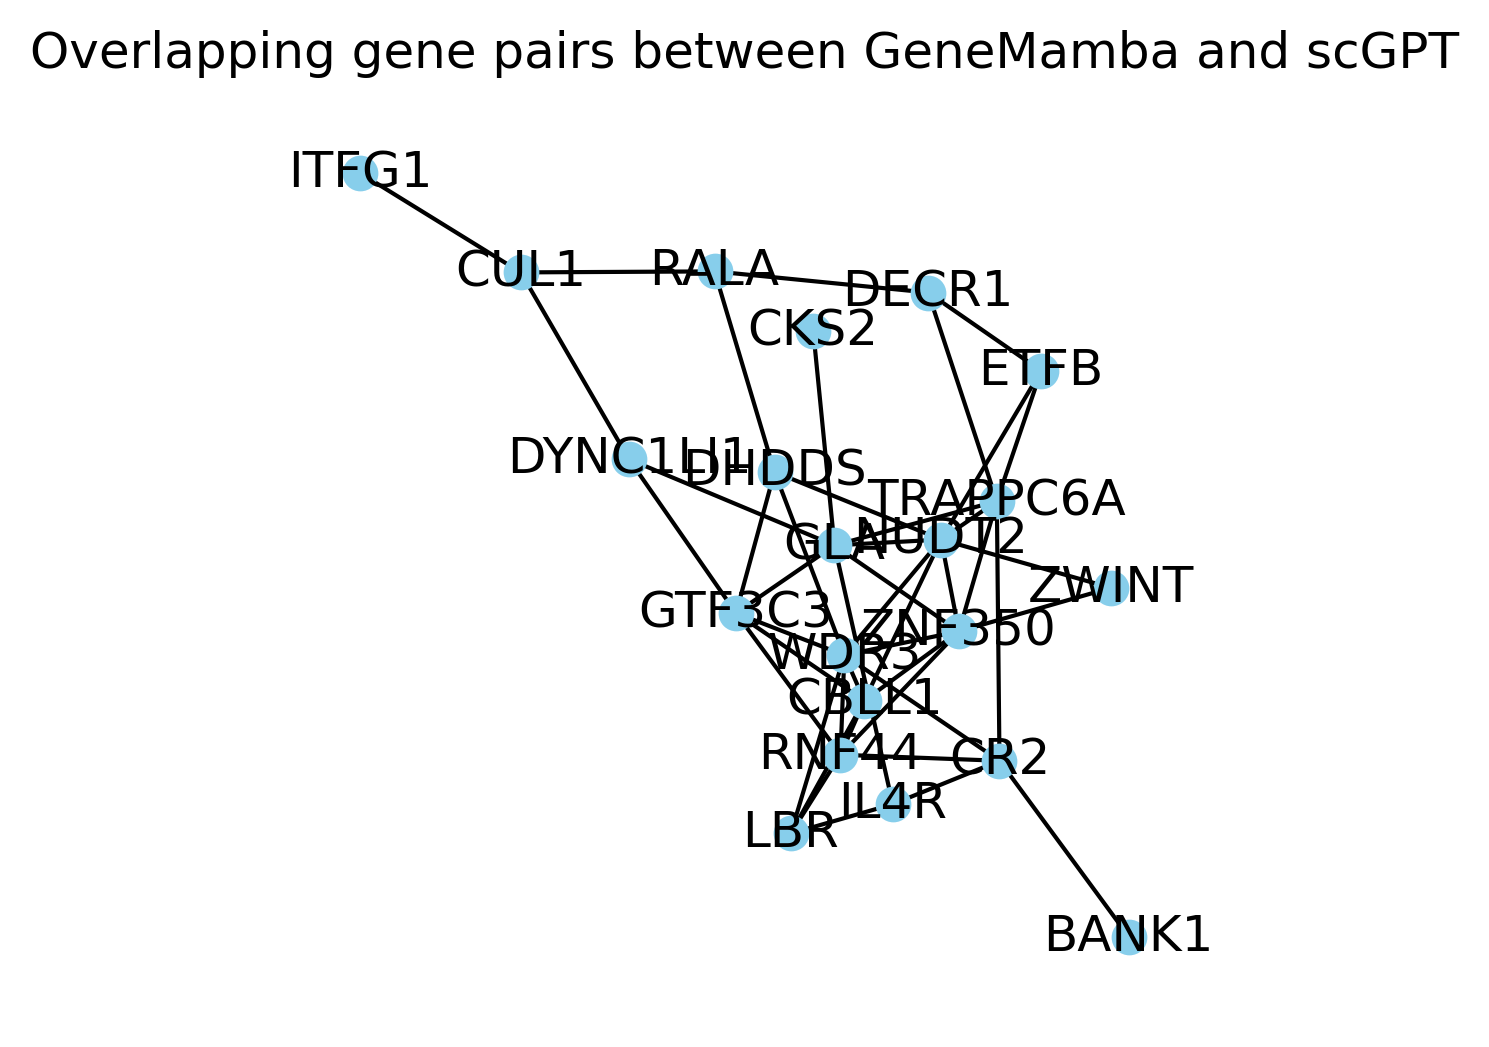

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_overlapping_pairs(overlapping_edges, common_gene_names):
    G = nx.Graph()

    for edge in overlapping_edges:
        G.add_edge(common_gene_names[edge[0]], common_gene_names[edge[1]])

    plt.figure(figsize=(4, 4), dpi=300)

    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, labels={gene: gene for gene in G.nodes()}, font_size=12, font_color='black')

    # hide all spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.title("Overlapping gene pairs between GeneMamba and scGPT", fontsize = 12)
    plt.show()


visualize_overlapping_pairs(overlapping_edges, common_gene_names)

In [22]:
overlapping_genes = set([common_gene_names[edge[0]] for edge in overlapping_edges] + 
                        [common_gene_names[edge[1]] for edge in overlapping_edges])

print("overlapping_genes: ", overlapping_genes)

overlapping_genes:  {'NUDT2', 'IL4R', 'RNF44', 'ZWINT', 'ZNF350', 'CBLL1', 'GTF3C3', 'DHDDS', 'TRAPPC6A', 'CUL1', 'ITFG1', 'GLA', 'DECR1', 'BANK1', 'WDR3', 'LBR', 'DYNC1LI1', 'RALA', 'CKS2', 'CR2', 'ETFB'}


In [23]:
with open("overlapping_genes.txt", "w") as f:
    for gene in overlapping_genes:
        gene_id = model.symbol2id[gene]
        f.write(f"{gene} {gene_id}\n")

['DECR1', 'RALA', 'CBLL1', 'IL4R', 'CR2', 'TRAPPC6A', 'GLA', 'ZWINT', 'GTF3C3', 'RNF44', 'LBR', 'ZFAND3', 'ETFB', 'CKS2', 'NUDT2', 'CUL1', 'ZNF350', 'BANK1', 'ITFG1', 'DYNC1LI1', 'CFP', 'WDR3', 'DHDDS']
['DECR1', 'RALA', 'NKG7', 'CBLL1', 'IL4R', 'CR2', 'CST7', 'TRAPPC6A', 'ZWINT', 'GTF3C3', 'RNF44', 'LBR', 'RPLP1', 'ZFAND3', 'ETFB', 'CKS2', 'CUL1', 'ZNF350', 'BANK1', 'ITFG1', 'DYNC1LI1', 'CFP', 'WDR3', 'DHDDS']
['DECR1', 'RALA', 'NKG7', 'CBLL1', 'IL4R', 'CR2', 'CST7', 'TRAPPC6A', 'GLA', 'ZWINT', 'GTF3C3', 'RNF44', 'LBR', 'RPLP1', 'ZFAND3', 'ETFB', 'CKS2', 'NUDT2', 'CUL1', 'ZNF350', 'BANK1', 'ITFG1', 'DYNC1LI1', 'CFP', 'WDR3', 'DHDDS']


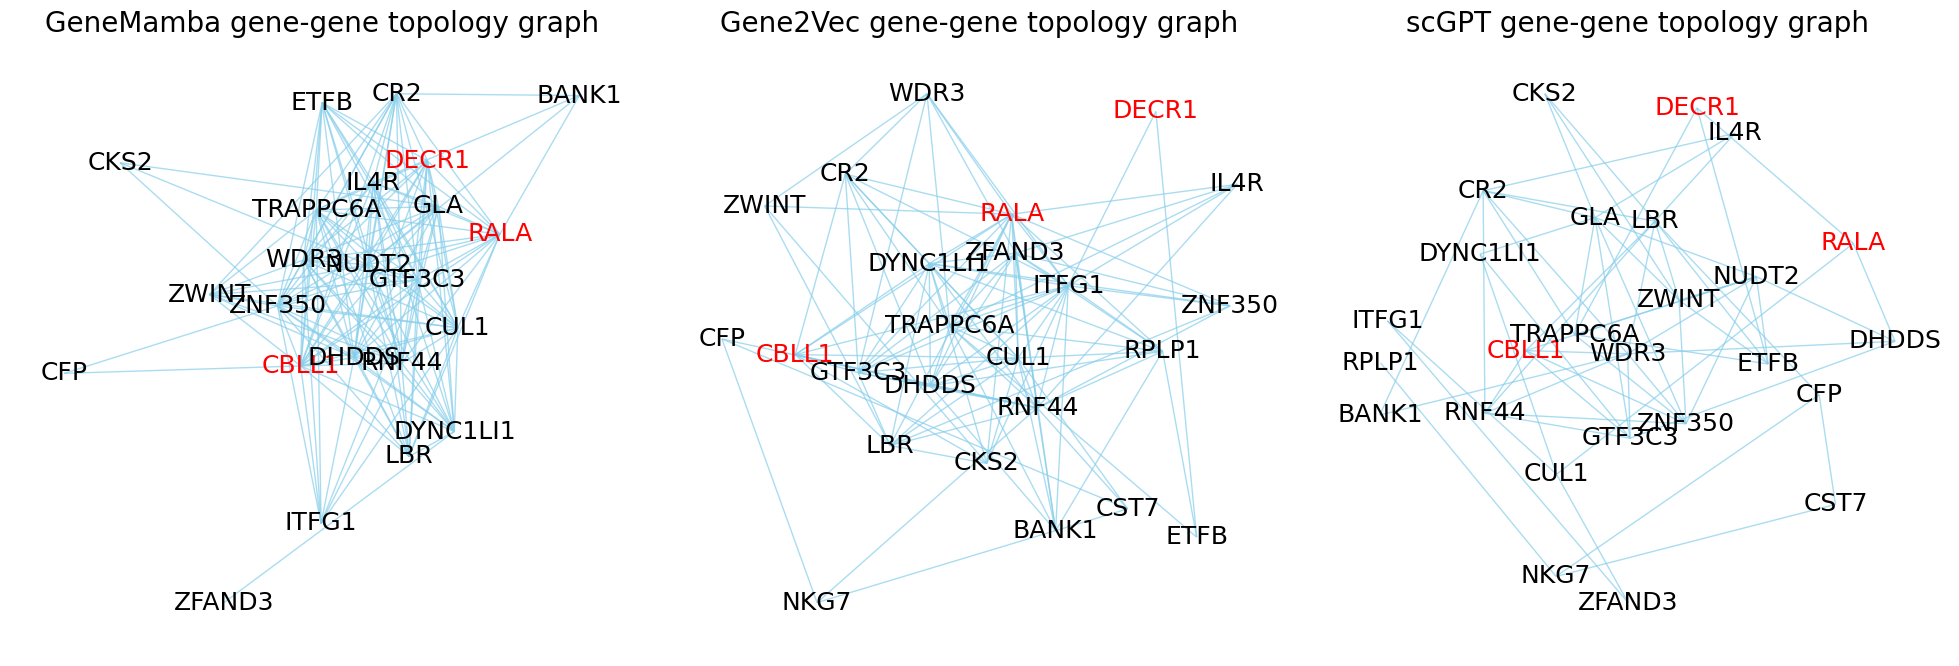

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_subplot(ax, adjacent_matrix, model_name, common_df):
    G = nx.from_numpy_array(adjacent_matrix)
    mapping = {i: common_df.iloc[i]["Gene1"] for i in range(len(common_df))}
    G = nx.relabel_nodes(G, mapping)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    pos = nx.spring_layout(G, seed=42, k=1.5)
    
    nx.draw_networkx_edges(
        G, pos = pos, ax=ax, edge_color="skyblue", alpha=0.7
    )

    
    # draw labels with different colors for the overlapping genes
    print(G.nodes)
    labels = {node: node for node in G.nodes}
    label_colors = {node: "red" if node in {"RALA", "DECR1", "CBLL1"} else "black" for node in G.nodes}
    
    for node, (x, y) in pos.items():
        ax.text(
            x, y, labels[node],
            fontsize=18, color=label_colors[node],
            horizontalalignment='center', verticalalignment='center'
        )

    ax.set_title(f"{model_name} gene-gene topology graph", fontsize=20)

    # hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig, axes = plt.subplots(1, 3, figsize=(20, 7)) 

# call the function for each model
visualize_graph_subplot(axes[0], adjacent_matrix_mamba, "GeneMamba", common_df)
visualize_graph_subplot(axes[1], adjacent_matrix_g2v, "Gene2Vec", common_df)
visualize_graph_subplot(axes[2], adjacent_matrix_scgpt, "scGPT", common_df)

plt.tight_layout()
plt.show()